In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from HelperFunctions import AcceptOrReject

## Define the log of the target density function

In [2]:
rho= 0.5
cov = np.array([[1.0, rho],
                [rho, 1.0]])

chol = la.cho_factor(cov, lower=True)

def LogTargetDensity(x):
    """ Returns the log posterior (up to a normalizing constant) """
    
    return -0.5*x.dot( la.cho_solve(chol,x))
    
    

## Generate direct Monte Carlo samples

In [3]:
num_batches = 100
num_samps = 2000

mc_samps = np.zeros((num_samps,2,num_batches))
for i in range(num_batches):
    mc_samps[:,:,i] = np.random.randn(num_samps,2) @ chol[0].T

## Generate MCMC samples


In [4]:
prop_std = 0.5

# Intialize empty arrays for the thickness samples the log posterior pdfs at each sample
mcmc_samps = np.zeros((num_samps,2,num_batches))
mcmc_samps[0,:,:] = mc_samps[0,:,:] # start with true target samples to avoid burnin

# Repeat the MCMC sampling a bunch of times
for batch_ind in range(num_batches):
    
    curr_log_dens = LogTargetDensity(mcmc_samps[0,:,batch_ind])
    
    # Metropolis-Hastings MCMC Loop
    for mcmc_it in range(num_samps-1):
        
        # Generate a proposed move
        prop = mcmc_samps[mcmc_it, :, batch_ind] + prop_std*np.random.randn(2)

        # Evaluate the log posterior at the proposed point
        prop_log_pdf = LogTargetDensity(prop)

        gamma = np.exp(prop_log_pdf - curr_log_dens)
        # Part of your pset is to figure out what's going on in the AcceptOrReject function
        should_accept = AcceptOrReject(gamma)

        if(should_accept):
            mcmc_samps[mcmc_it+1,:,batch_ind] = prop
            curr_log_dens = prop_log_pdf
        else:
            mcmc_samps[mcmc_it+1,:,batch_ind] = mcmc_samps[mcmc_it,:,batch_ind]


## Compute runnning means

In [5]:
Ns = np.tile( np.arange(1,num_samps+1).reshape(-1,1,1), (1,2,num_batches))
mc_means = np.cumsum(mc_samps,axis=0)/Ns
mcmc_means = np.cumsum(mcmc_samps, axis=0)/Ns

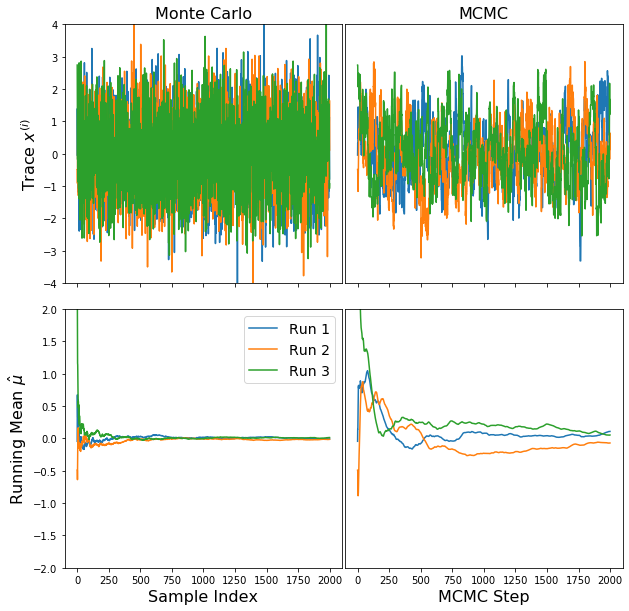

In [6]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10), sharex=True)
axs[0,0].plot(mc_samps[:,0,0])
axs[0,0].set_ylim([-4,4])

axs[0,1].set_ylim([-4,4])
axs[0,1].get_yaxis().set_ticks([])
axs[0,1].plot(mcmc_samps[:,0,0])

axs[1,0].plot(mc_means[:,0,0], label='Run 1')
axs[1,0].set_ylim([-2,2])

axs[1,1].plot(mcmc_means[:,0,0])
axs[1,1].set_ylim([-2,2])
axs[1,1].get_yaxis().set_ticks([])


axs[0,0].set_title('Monte Carlo',fontsize=16)
axs[0,1].set_title('MCMC',fontsize=16)

axs[0,0].set_ylabel('Trace $x^{(i)}$',fontsize=16)
axs[1,0].set_xlabel('Sample Index',fontsize=16)
axs[1,1].set_xlabel('MCMC Step',fontsize=16)
axs[1,0].set_ylabel('Running Mean $\hat{\mu}$',fontsize=16)

plt.subplots_adjust(wspace=0.01, hspace=0.1) 
plt.savefig('Comparison1.png')


axs[0,0].plot(mc_samps[:,0,1])
axs[0,0].set_ylim([-4,4])

axs[0,1].set_ylim([-4,4])
axs[0,1].get_yaxis().set_ticks([])
axs[0,1].plot(mcmc_samps[:,0,1])

axs[1,0].plot(mc_means[:,0,1], label='Run 2')
axs[1,0].set_ylim([-2,2])

axs[1,1].plot(mcmc_means[:,0,1])
axs[1,1].set_ylim([-2,2])
axs[1,1].get_yaxis().set_ticks([])


axs[0,0].plot(mc_samps[:,0,2])
axs[0,0].set_ylim([-4,4])

axs[0,1].set_ylim([-4,4])
axs[0,1].get_yaxis().set_ticks([])
axs[0,1].plot(mcmc_samps[:,0,2])

axs[1,0].plot(mc_means[:,0,2],label='Run 3')
axs[1,0].set_ylim([-2,2])

axs[1,1].plot(mcmc_means[:,0,2])
axs[1,1].set_ylim([-2,2])
axs[1,1].get_yaxis().set_ticks([])

axs[1,0].legend(fontsize=14)
plt.savefig('Comparison2.png')

plt.show()

### Plot the estimator standard deviation over time

In [12]:
mc_var = np.var(mc_means, axis=2)
mcmc_var = np.var(mcmc_means, axis=2)

mc_std = np.sqrt(mc_var)
mcmc_std = np.sqrt(mcmc_var)


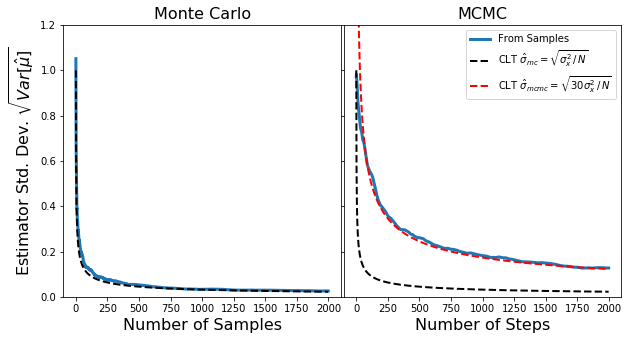

In [45]:
fig, axs = plt.subplots(ncols=2,figsize=(10,5), sharey=True)
axs[0].plot(mc_std[:,0], linewidth=3, label='From Samples')
axs[0].plot(np.sqrt( 1.0 / np.arange(1,num_samps+1)), '--k',linewidth=2, label='CLT')

axs[1].plot(mcmc_std[:,1], linewidth=3, label='From Samples')
axs[1].plot(np.sqrt( 1.0 / np.arange(1,num_samps+1)), '--k',linewidth=2, label='CLT $\hat{\sigma}_{mc}=\sqrt{\sigma_x^2\,/\,N}$')
axs[1].legend(fontsize=14)
axs[1].set_ylim(0,1.2)

plt.subplots_adjust(wspace=0.01)
axs[0].set_ylabel('Estimator Std. Dev. $\sqrt{Var[\hat{\mu}]}$', fontsize=16)
axs[0].set_xlabel('Number of Samples', fontsize=16)
axs[1].set_xlabel('Number of Steps', fontsize=16)
axs[0].set_title('Monte Carlo', fontsize=16)
axs[1].set_title('MCMC',fontsize=16)

plt.savefig('StandardError.png')

axs[1].plot(np.sqrt(30.0)* np.sqrt( 1.0 / np.arange(1,num_samps+1)), '--r',linewidth=2, label='CLT $\hat{\sigma}_{mcmc}=\sqrt{30\sigma_x^2\,/\,N}$')
axs[1].set_ylim(0,1.2)
axs[1].legend()
plt.savefig('StandardErrorScaled.png')

plt.show()

### Scatter plot for correlation

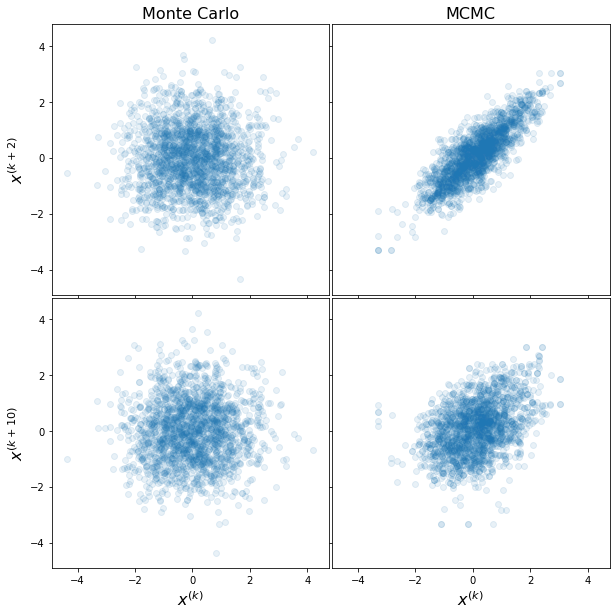

In [57]:
fig,axs =plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True, figsize=(10,10))

delay1=2
axs[0,0].scatter(mc_samps[0:-delay1,0,0],mc_samps[delay1:,0,0], alpha=0.1)
axs[0,1].scatter(mcmc_samps[0:-delay1,0,0],mcmc_samps[delay1:,0,0], alpha=0.1)


delay2= 10
axs[1,0].scatter(mc_samps[0:-delay2,0,0],mc_samps[delay2:,0,0], alpha=0.1)
axs[1,1].scatter(mcmc_samps[0:-delay2,0,0],mcmc_samps[delay2:,0,0], alpha=0.1)

axs[1,0].set_xlabel('$x^{(k)}$',fontsize=16)
axs[1,0].set_ylabel('$x^{(k+%d)}$'%delay2,fontsize=16)
axs[0,0].set_ylabel('$x^{(k+%d)}$'%delay1,fontsize=16)
axs[1,1].set_xlabel('$x^{(k)}$',fontsize=16)

axs[0,0].set_title('Monte Carlo',fontsize=16)
axs[0,1].set_title('MCMC',fontsize=16)
plt.subplots_adjust(wspace=0.01,hspace=0.01)

plt.savefig('CorrelationScatter.png')


In [81]:
mc_corr = np.correlate(mc_samps[:,0,1], mc_samps[:,0,1], mode='same')
mcmc_corr = np.correlate(mcmc_samps[:,0,1], mcmc_samps[:,0,1], mode='same')

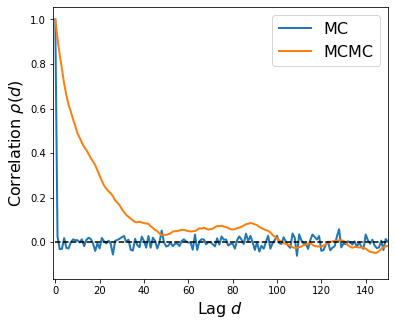

In [96]:
plt.figure(figsize=(6,5))
plt.plot(mc_corr[int(num_samps/2):]/np.max(mc_corr), linewidth=2,label='MC')
plt.plot(mcmc_corr[int(num_samps/2):]/np.max(mcmc_corr), linewidth=2,label='MCMC')
plt.xlabel('Lag $d$',fontsize=16)
plt.ylabel('Correlation $\\rho (d)$',fontsize=16)
plt.legend(fontsize=16)
plt.xlim([-1,150])
plt.plot([0,200],[0,0],'--k')

plt.savefig('Autocorrelation.png')
plt.show()
